<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [10]</a>'.</span>

In [1]:
from edc import check_compatibility
check_compatibility("user-0.24.5", dependencies=["XCUBE_GEN"])



---------

The following environment variables are available:

* `XCUBE_GEN_AUTH_AUD`, `XCUBE_GEN_API_SERVER_PORT`, `XCUBE_GEN_AUTH_DOMAIN`, `XCUBE_GEN_AUTH_CLIENT_ID`, `XCUBE_GEN_AUTH_CLIENT_SECRET`, `XCUBE_GEN_API_SERVER_URL`


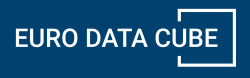  &nbsp; &nbsp; &nbsp; 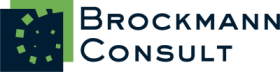

# xcube Data Cube Generator with custom processing

### Phi-Week 2021

#### brought to you by Brockmann Consult



In [2]:
# This is needed to nicely show the images accessible via the environment variable EDC_PATH
import os
from IPython.display import display, Image

In [3]:
# Paths to necessary images

MCI_formula = f'{os.environ["EDC_PATH"]}/notebooks/contributions/xcube_processing/MCI_formula.png'
xcube_generator_overview = f'{os.environ["EDC_PATH"]}/notebooks/contributions/xcube_processing/generator.png'
xarray_datasets = f'{os.environ["EDC_PATH"]}/notebooks/contributions/xcube_processing/xarray_datasets.png'

### Introduction

We are interested in Water Quality and would like to use satellite data for some analysis.   
The Maximum Chlorophyll Index (MCI) is a great for that, because it is a robust indicator for critical eutrophication situation in any water body and it is used for identification of exceptional situations related to phytoplankton. 

The MCI can be derived from both, Sentinel 3 and Sentinel 2 because they have suitable spectral bands. This is the formula for MCI, but we will not go into detail there.

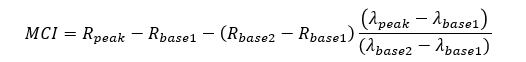

In [4]:
display(Image(filename=MCI_formula))

Let's use Sentinel 2 for our example, we need following bands

- B04 - Wavelength 665nm
- B05 - Wavelength 704nm
- B06 - Wavelength 740nm
- SCL - Scene classification data, based on Sen2Cor processor
- CLD - Cloud probability, based on Sen2Cor processor

OK - how does the xcube Generator help here? 

### xcube & xcube processing
xcube is an open source software to generate, manipulate, analyse, and publish data cubes from EO data.  
xcube processing has the ambition to bridge the gap from data access to analysis-ready products. 
xcube is developed by Brockmann Consult and it is one of the approaches to integrate Your Own Algorithm to the EDC Marketplace.

Let's have a look how it is strucktured:

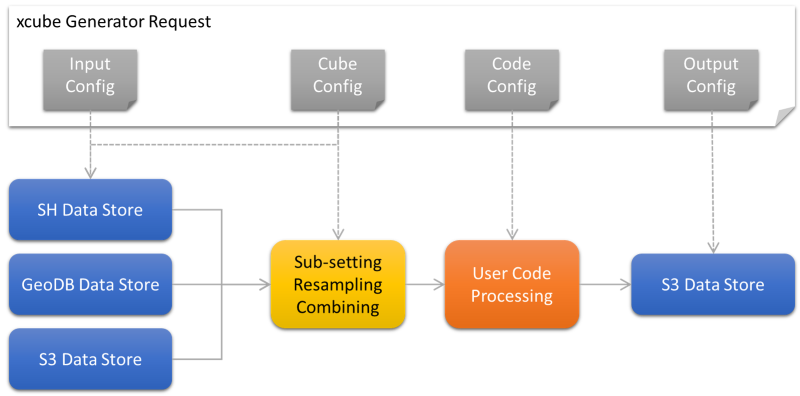

In [5]:
display(Image(filename=xcube_generator_overview))

#### By the way, what are data cubes? 

An xcube dataset contains one or more (geo-physical) data variables whose values are stored in cells of a common multi-dimensional, spatio-temporal grid. The dimensions are usually time, latitude, and longitude, however other dimensions may be present.

Visualisation by [xarray](http://xarray.pydata.org/en/stable/index.html):


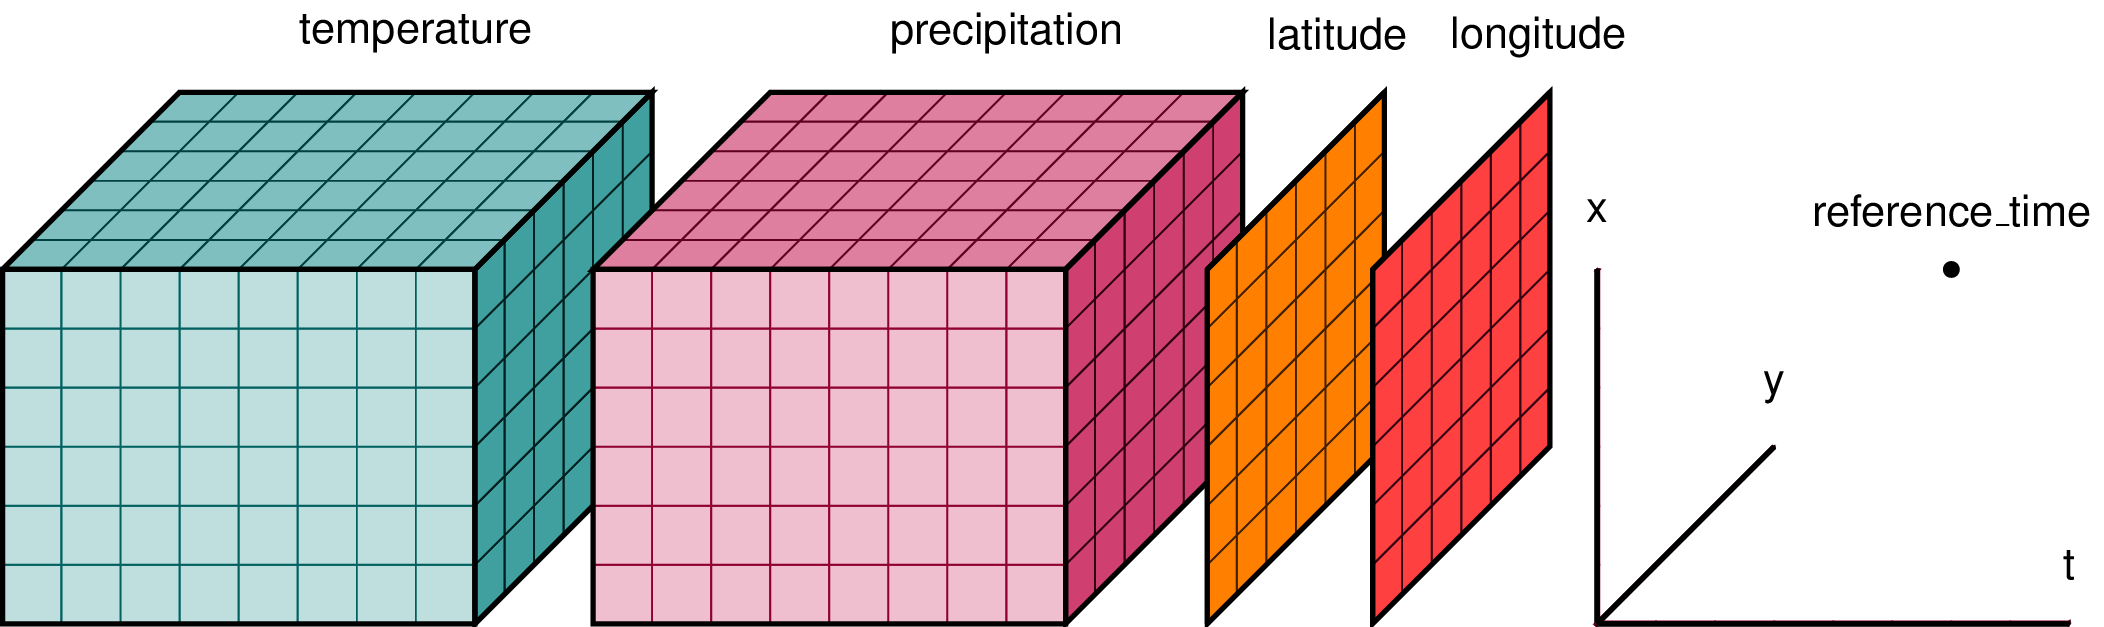

In [6]:
display(Image(filename=xarray_datasets))

This Notebook comprises four sections that describe a typical algorithm development process with xcube BYOA:


**1. Fetch Subset Source Cube** request a subset data cube containing the needed input bands  
**2. Develop Algorithm** and apply to subset source cube  
**3. Package Algorithm** and test with subset source cube  
**4. Run Generator Service with processing** on larger dataset  


### 1. Fetch Subset Source Cube

Here is how we create _cube Generator Request_ from Python classes. 
First import the relevant classes for setting up a generator request, then
we define the input, output and the cube characteristics, finally the request.

In this example we first use the **[Sentinel Hub](https://www.sentinel-hub.com/)** data store as input and 
a **local directory** (the current one) data store as output:

**NOTE:** You need to purchace *EDC xcube Generator* with at least a *medium* plan together with *xcube processing* ([EDC xcube Generator](https://eurodatacube.com/marketplace/services/edc_xcube_generator))

In [7]:
import IPython.display
import shapely.geometry


In [8]:
bbox=[12.00, 43.05, 12.20, 43.21] # Lago Trasimeno in Italy
target_res_m = 100. # desired target resolution

In [9]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Import the generator class:

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [10]:
from xcube.core.gen2 import InputConfig
from xcube.core.gen2 import CubeConfig
from xcube.core.gen2 import OutputConfig
from xcube.core.gen2 import CubeGeneratorRequest
from xcube.core.gen2 import CubeGenerator
from xcube.core.gen2 import ServiceConfig

from xcube.core.dsio import open_cube 
from math import radians, cos
import xarray as xr

%matplotlib inline

ImportError: cannot import name 'ServiceConfig' from 'xcube.core.gen2' (/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/xcube/core/gen2/__init__.py)

In [ ]:
# function to calculate degrees from meters
def deg_lon_from_m(m, lat_deg):
    one_degree_at_equator = 111319
    return m / (one_degree_at_equator * cos(radians(lat_deg)))

Instantiate the generator object

In [ ]:
input_config = InputConfig(
    store_id="sentinelhub",
    data_id="S2L2A",
    open_params=dict(
        time_tolerance="30m"
    )
)

cube_config = CubeConfig(
   variable_names=['B04', 'B05', 'B06', 'SCL', 'CLD'],
   tile_size=[512, 512],
   spatial_res=deg_lon_from_m(target_res_m, (bbox[1]+bbox[3])/2.),           
   bbox = bbox,      
   time_period="4D",                         
   time_range=['2021-07-01', '2021-08-31'],  # 2 months / 4 days --> 16 time steps       
)

output_config = OutputConfig(
    store_id="file",
    store_params=dict(
        root="."
    ),
    replace=True,
    data_id="cube_italy.zarr"
)

In [ ]:
request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    output_config=output_config
)

request

In [ ]:
local_generator = CubeGenerator.new()

Get some information about the cube that would be generated by `local_generator` (this may take seconds to minutes):

In [ ]:
cube_info = local_generator.get_cube_info(request)
cube_info

Now perform the actual cube generation (again, this may take seconds to minutes):

In [ ]:
result = local_generator.generate_cube(request)
result

A reference to the generated cube is found in the `result` object using its `result` property:

In [ ]:
cube_id = result.result.data_id

Let's open the generated cube:

In [ ]:
source_cube = open_cube(cube_id)
source_cube

### 2. Algorithm Development

Now that we have the data cube, we want to start some algorithm development. Namely, we want to generate a new data layer called _Maximum Chlorophyll Index (MCI)_ for inland waters from the S2L2A bands `B04`, `B05`, and `B06`. 

In [ ]:
source_cube.B05

In [ ]:
source_cube.B05.isel(time=-1).plot.imshow(figsize=(20, 15), vmin=0, vmax=0.2, cmap='Greys_r')

We want the algorithm to operator only on water pixels. 
Luckily the S2L2A dataset above provides some _scene classification flags_ in variable `SCL` that we can
use to mask out unwanted land and cloud pixels.

In [ ]:
from xcube.core.maskset import MaskSet

scene_classif = MaskSet(source_cube.SCL)
scene_classif

In [ ]:
scene_classif.water

In [ ]:
scene_classif.water.isel(time=-1).plot.imshow(figsize=(20, 15))

We'll now code the algorithm:

In [ ]:
from typing import Any, Dict
import numpy as np


def compute_mci_var(b_from: np.ndarray, 
                    b_peek: np.ndarray,
                    b_to: np.ndarray, 
                    input_params: Dict[str, Any], 
                    dim_coords: Dict[str, np.ndarray]):
    """Compute Maximum Chlorophyll Index (MCI) from three reflectances."""
    
    # The first three arguments are chunks of the three input variables we define below. 
    # You can name them as you like. They are pure 3D numpy arrays.
    
    # The 'input_params' argument is a standard parameter that we define in the call below.
    wlen_from = input_params['wlen_from']
    wlen_peek = input_params['wlen_peek']
    wlen_to = input_params['wlen_to']
    
    # The 'dim_coords' argument is optional and provides the coordinate values for all dimension 
    # of the current chunk. We don't use it here, but for many algorithms this is important 
    # information (e.g. looking up aux data).
    lon, lat = (dim_coords[dim] for dim in ('lon', 'lat'))
    # print('dim_coords from', lon[0], lat[0], 'to', lon[-1], lat[-1])
    
    # You can use any popular data packages such as numpy, scipy, dask here,
    # or we can use ML packages such as scikitlearn!
    # For simplity, we do some simple array math here:

    f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
    mci = (b_peek - b_from) - f * (b_to - b_from)

    return mci

We now write the actual _dataset processor function_. We already code in the way xcube expects it for the generator service. This is, the function's first argument is the data cube (of type `xr.Dataset`) generated so far according to `cube_config` and `input_config` xcubes expects it to. The remaining keyword-arguments are later provided by the user through the `code_config` object. The return value must again be a data cube (of type `xr.Dataset`).

We use the xcube function `compute_cube` to apply our MCI-algorithm to each of the cube's chunks. Finally we store some metadata in our output.

In [ ]:
from xcube.core.compute import compute_cube

def compute_mci_cube(source_cube: xr.Dataset, **processing_params) -> xr.Dataset:
    """
    Compute a new data cube with a single variable 'mci' (Maximum Chlorophyll Index) 
    from three reflectances.
    
    Note the parameter *processing_params* can be used to pass user-defined
    parameters into the function. However, they are not used here.
    """
    
    # Mask out non-water pixels
    scene_classif = MaskSet(source_cube.SCL)    
    water_cube = source_cube.where(scene_classif.water)
    
    input_params = dict(wlen_from=water_cube.B04.attrs['wavelength'],
                        wlen_peek=water_cube.B05.attrs['wavelength'],
                        wlen_to=water_cube.B06.attrs['wavelength'])
    
    # concurrently compute the cube; chunks are processed in parallel
    mci_cube = compute_cube(compute_mci_var, 
                            water_cube, 
                            input_var_names=['B04', 'B05', 'B06'], 
                            input_params=input_params, 
                            output_var_name='MCI')
    # the MCI variable
    mci = mci_cube['MCI']

    # Return a copy of the source cube plus the MCI variable
    mci.attrs['long_name'] = 'Maximum Chlorophyll Index'
    mci.attrs['units'] = 'unitless'

    # Return a copy of the source cube plus the MCI variable
    return source_cube.assign(MCI=mci.astype(np.float32))    

We can now call the processor function `compute_mci_cube` to generate a new cube that contains the `MCI` variable. Note that no computation is performed yet. Chunks will be computed once demanded. For every requested chunk, the function `compute_mci_var` is called.

In [ ]:
mci_cube = compute_mci_cube(source_cube)
mci_cube

The dataset looks ok, now visually inspect MCI:

In [ ]:
mci_cube.MCI.isel(time=-1).plot.imshow(figsize=(20, 15), vmin=0, vmax=0.02, cmap='plasma')

In [ ]:
mci_cube.MCI.plot.imshow(col='time', col_wrap=4, vmin=0, vmax=0.02, cmap='plasma', figsize=(20, 15))

### 3. Algorithm Packaging

We now have a tiny local data cube and a working algorithm. Now the final goal is to scale up and 
run the algorithm remotely, on much more data, and with much much more computational power.

Before we proceed to the EDC xcube Generator Service, we will try running the local cube generator 
with our code. This will allow us finding bugs early, which is much harder with the algorithm 
executed by the serivce. If it runs fine locally, we have more confidence when running the 
algorithm remotely.

Because the `compute_mci_cube()` function comprises  only little code, we use the
`CodeConfig.from_code()` method to create a code configuration that uses one single inline code
string which will be passed to the generator: 

In [ ]:
from xcube.core.gen2 import CodeConfig

code_config = CodeConfig.from_code(
    # Pass required imports as inline code.    
    "from typing import Any, Dict",
    "import numpy as np",
    "import xarray as xr",
    "from xcube.core.maskset import MaskSet",
    "from xcube.core.compute import compute_cube",
    # Functions can be passed as references
    compute_mci_cube,
    compute_mci_var,
    module_name='mci_processor',
)

In [ ]:
# Call code_config.get_callable() to test whether code_config is valid.
# If it is valid, it should return a function refernce.
code_config.get_callable()

Two code configuration factory methods can be used for convenience, while the algorithm code base remains small:

* `CodeConfig.from_code(*code, ...)` - The one used above, it creates an inline code string configuration.
* `CodeConfig.from_callable(function, ...)` - Detects the code base for the given *function* given that it is defined in a file, creates a Python module, then creates a code configuration for it.

If our algorithm code base grows, we should consider developing a Python module. Then we can provide a reference to its directory
directly or pack it as a Zip archive, or even host it on GitHub and use a GitHub release:

* `CodeConfig.from_file_set(file_set, ...)` - Creates a code configuration for a Python module (directory or Zip archive), local or remote. You can use URLs with **https** or **s3** protocol that point to Zip archives.
* `CodeConfig.from_github_archive(gh_org, gh_repo, ...)` - Creates a code configuration for a GitHub archive (still experimental).

Once we have a working code configuration, we can create the generator request:

### 4. Run BYOA Generator Service

After packaging the algorithm, the final goal is to scale up and run the algorithm remotely, on more data, and with more computational power. See also Notebook [xcube Remote Cube Generator](./3_remote.ipynb)

We use the EuroDataCube xcube Generator service for scaling up. 

In [ ]:
bbox=[11.83, 42.05, 12.32, 43.21] # Italian Lakes close to Rome
target_res_m = 100.

In [ ]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

Both the local Data Cube Generator and the Cube Generator Service clients use the same generator request format. It comprises specification of data sources (`input_config`), the data cube parameters (`cube_config`), the optional specification of optional user code (`code_config`), and finally the specification of the data sink (`output_config`). The `input_config` and `output_config` specifications refernce instances of _xcube Data Stores_ (see dedicated example Notebooks).

In [ ]:
cube_config = CubeConfig(
   variable_names=['B04', 'B05', 'B06', 'SCL', 'CLD'],
   tile_size=[512, 512],
   spatial_res=deg_lon_from_m(target_res_m, (bbox[1]+bbox[3])/2.),
   bbox=bbox,        
   time_period="4D",                         
   time_range=['2021-08-01', '2021-08-31'],  # 2 months / 4 days --> 16 time steps
   metadata=dict(title='Italian Lakes August 2021'), 
)

In [ ]:
input_config = InputConfig(
    # This refers to the Sentinel Hub deployment in Europe. 
    store_id="@sentinelhub_eu",
    data_id="S2L2A",
    open_params=dict(
        time_tolerance="30m"
    )
)

output_config = OutputConfig(
    # This refers to https://s3.eu-central-1.amazonaws.com/eurodatacube-scratch/
    store_id="@eurodatacube_scratch", # cubes stored in eurodatacube-scratch bucket persist for 4 days
    replace=True,
    data_id="Italian_Lakes_phiweek2021.zarr"
)

service_request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    code_config=code_config,
    output_config=output_config
)
service_request

The manual creation of the service_config_json will not be required in future versions.


We create a new remote cube generator with the service configuration from an external file:

In [ ]:
edc_service_path = f'{os.environ["EDC_PATH"]}/notebooks/contributions/xcube_processing/edc-service.yml'

In [ ]:
generator_service = CubeGenerator.new(service_config=edc_service_path, verbosity=1)

In [ ]:
generator_service.get_cube_info(service_request)

Let's invoke the generator service. This time we catch a possible cube generator error, so we can analyse it later.

In [ ]:
from xcube.core.gen2 import CubeGeneratorError

result = generator_service.generate_cube(service_request)
result

If `result.status` is `"warning"` or `"error"`, the fields `result.message`, `result.traceback`, and `result.output` may provide more information about the source of the error.

If `result.status` is `"ok"`, we should have a valid `cube_id` in the cube reference `result.result`. 

In [ ]:
cube_id = result.result.data_id

In [ ]:
cube_id

We can open the generated cube directly from the `@eurodatacube_scratch` data store since it refers to a public read-only S3 bucket on AWS. Its URL template is

    https://s3.eu-central-1.amazonaws.com/eurodatacube-scratch/{cube_id}

We use the xcube function `open_cube` to open cubes from a URL: 

In [ ]:
cube = open_cube(f'https://s3.eu-central-1.amazonaws.com/eurodatacube-scratch/{cube_id}', s3_kwargs=dict(anon=True))

In [ ]:
cube

In [ ]:
cube.MCI.isel(time=-1).plot.imshow(figsize=(15, 25), vmin=0, vmax=0.02, cmap='plasma')